In [1]:
# import dependencies
import pandas as pd
import numpy as np
import copy, math
import matplotlib.pyplot as plt
from statistics import mean
from mpl_toolkits import mplot3d
from sklearn.linear_model import SGDRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
np.set_printoptions(precision=2)


%matplotlib inline

In [2]:
# show all columns
pd.set_option('display.max_columns', None)

## Load in Dataset

In [3]:
ccCustomersCSv = pd.read_csv('Resources/BankChurners.csv')

In [4]:
ccCustomersCSv.head()

,CLIENTNUM,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1,Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2
0,768805383,Existing Customer,45,M,3,High School,Married,$60K - $80K,Blue,39,5,1,3,12691.0,777,11914.0,1.335,1144,42,1.625,0.061,0.000093,0.99991
1,818770008,Existing Customer,49,F,5,Graduate,Single,Less than $40K,Blue,44,6,1,2,8256.0,864,7392.0,1.541,1291,33,3.714,0.105,0.000057,0.99994
2,713982108,Existing Customer,51,M,3,Graduate,Married,$80K - $120K,Blue,36,4,1,0,3418.0,0,3418.0,2.594,1887,20,2.333,0.000,0.000021,0.99998
3,769911858,Existing Customer,40,F,4,High School,Unknown,Less than $40K,Blue,34,3,4,1,3313.0,2517,796.0,1.405,1171,20,2.333,0.760,0.000134,0.99987
4,709106358,Existing Customer,40,M,3,Uneducated,Married,$60K - $80K,Blue,21,5,1,0,4716.0,0,4716.0,2.175,816,28,2.500,0.000,0.000022,0.99998


In [5]:
# some rows have the value 'Unknown' in the income category & educatin level columns, filtering those out
filtered_df = ccCustomersCSv[ccCustomersCSv['Income_Category'].str.contains('Unknown')== False]
filtered_df = filtered_df[ccCustomersCSv['Education_Level'].str.contains('Unknown')== False]

/var/folders/4b/ltxykyrn7j9bt96tg5cjy76h0000gn/T/ipykernel_10017/117354373.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  filtered_df = filtered_df[ccCustomersCSv['Education_Level'].str.contains('Unknown')== False]


### Below, we are testing the weight of education level and marital status on credit limit. We are changing values to numbers based on the below qualities.
    - the higher your education the higher the number you get
    - Married gets the highest number, followed by single and so on (kind of based on stability, we'd imagine a single person to be more stable than a divorced person)

In [6]:
# Change the values in the Income Category column to numerical values, we picked the value that fell between specified range
filtered_df.loc[filtered_df['Income_Category']== '$60K - $80K', 'Income_Category'] = 70000
filtered_df.loc[filtered_df['Income_Category']== 'Less than $40K', 'Income_Category'] = 20000
filtered_df.loc[filtered_df['Income_Category']== '$80K - $120K', 'Income_Category'] = 100000
filtered_df.loc[filtered_df['Income_Category']== '$40K - $60K', 'Income_Category'] = 50000
filtered_df.loc[filtered_df['Income_Category']== '$120K +', 'Income_Category'] = 120000

In [7]:
# change the value of education to numerical weights
filtered_df.loc[filtered_df['Education_Level']== 'High School', 'Education_Level'] = 0.50
filtered_df.loc[filtered_df['Education_Level']== 'Graduate', 'Education_Level'] = 0.70
filtered_df.loc[filtered_df['Education_Level']== 'Uneducated', 'Education_Level'] = 0.25
filtered_df.loc[filtered_df['Education_Level']== 'College', 'Education_Level'] = 0.60
filtered_df.loc[filtered_df['Education_Level']== 'Post-Graduate', 'Education_Level'] = 0.80
filtered_df.loc[filtered_df['Education_Level']== 'Doctorate', 'Education_Level'] = 0.90

In [8]:
#  Changing marital status to numerical weights
filtered_df.loc[filtered_df['Marital_Status']== 'Married', 'Marital_Status'] = 0.90
filtered_df.loc[filtered_df['Marital_Status']== 'Single', 'Marital_Status'] = 0.80
filtered_df.loc[filtered_df['Marital_Status']== 'Divorced', 'Marital_Status'] = 0.70
filtered_df.loc[filtered_df['Marital_Status']== 'Unknown', 'Marital_Status'] = 0.80

In [9]:
#  Changing gender to numerical weights
filtered_df.loc[filtered_df['Gender']== 'M', 'Gender'] = 2.00
filtered_df.loc[filtered_df['Gender']== 'F', 'Gender'] = 0.80
# filtered_df.loc[filtered_df['Marital_Status']== 'Divorced', 'Marital_Status'] = 0.70
# filtered_df.loc[filtered_df['Marital_Status']== 'Unknown', 'Marital_Status'] = 0.80

## Find lowest credit limit and analyze similarities of customers that share that credit limit

In [10]:
# Create Dataframe to test out transformed features
newDF = filtered_df.copy()

In [11]:
newDF.describe()

,CLIENTNUM,Customer_Age,Dependent_count,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1,Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2
count,7.641000e+03,7641.000000,7641.000000,7641.000000,7641.000000,7641.000000,7641.000000,7641.000000,7641.000000,7641.000000,7641.000000,7641.000000,7641.000000,7641.000000,7641.000000,7641.000000,7641.000000
mean,7.392090e+08,46.303756,2.351525,35.950530,3.814553,2.343411,2.450988,8559.183209,1166.122628,7393.060581,0.759349,4415.400864,64.667190,0.711507,0.280656,0.157826,0.842174
std,3.693693e+07,7.958827,1.290410,7.941765,1.550470,0.999927,1.103059,9162.211045,813.282318,9171.863364,0.221131,3457.148069,23.745462,0.237953,0.278156,0.363277,0.363277
min,7.080821e+08,26.000000,0.000000,13.000000,1.000000,0.000000,0.000000,1438.300000,0.000000,3.000000,0.000000,510.000000,10.000000,0.000000,0.000000,0.000008,0.000569
25%,7.130198e+08,41.000000,1.000000,31.000000,3.000000,2.000000,2.000000,2507.000000,451.000000,1255.000000,0.630000,2109.000000,44.000000,0.583000,0.025000,0.000099,0.999670
50%,7.178958e+08,46.000000,2.000000,36.000000,4.000000,2.000000,2.000000,4343.000000,1280.000000,3292.000000,0.735000,3866.000000,67.000000,0.700000,0.184000,0.000181,0.999820
75%,7.732890e+08,52.000000,3.000000,40.000000,5.000000,3.000000,3.000000,10877.000000,1781.000000,9663.000000,0.858000,4751.000000,81.000000,0.818000,0.513000,0.000329,0.999900
max,8.283431e+08,73.000000,5.000000,56.000000,6.000000,6.000000,6.000000,34516.000000,2517.000000,34516.000000,3.397000,17995.000000,134.000000,3.714000,0.999000,0.999430,0.999990


In [12]:
# The below was an attempt at engineering a feature , wasn't that helpful in long run

# dependentADJ = ((1+newDF['Dependent_count'])* newDF['Avg_Utilization_Ratio'])
# compositeEval = (newDF['Months_on_book']* newDF['Education_Level'] * newDF['Marital_Status'])

# newDF['Transformed'] = (newDF['Income_Category']/(compositeEval * dependentADJ))/10
# newDF['Transformed'] = newDF['Gender'] * ( newDF['Income_Category'] * ( (newDF['Months_on_book']* newDF['Education_Level'] * newDF['Marital_Status'])
#                                                      / ( (1 + newDF['Dependent_count']) + (1+newDF['Avg_Utilization_Ratio']) ) ) )/1000

### Find lowest credit limit

In [13]:
# lowest credit limit 
newDF['Credit_Limit'].min()

1438.3

### Find highest credit limit

In [14]:
# highest credit limit 
newDF['Credit_Limit'].max()

34516.0

In [15]:
# Customers with lower credit limits, 8559.18 is the average credit limit for all customers
lowCredLimit = newDF.loc[(newDF['Credit_Limit'] >= 1438.3) & (newDF['Credit_Limit'] < 8559.18)]

In [16]:
# Customers with higher credit limits
highCredLimit = newDF.loc[(newDF['Credit_Limit'] > 8559.18) & (newDF['Credit_Limit'] <= 34516)]
highCredLimit.head()

,CLIENTNUM,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1,Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2
0,768805383,Existing Customer,45,2.0,3,0.5,0.9,70000,Blue,39,5,1,3,12691.0,777,11914.0,1.335,1144,42,1.625,0.061,0.000093,0.99991
7,818906208,Existing Customer,32,2.0,0,0.5,0.8,70000,Silver,27,2,2,2,29081.0,1396,27685.0,2.204,1538,36,0.714,0.048,0.000086,0.99991
8,710930508,Existing Customer,37,2.0,3,0.25,0.8,70000,Blue,36,5,2,0,22352.0,2517,19835.0,3.355,1350,24,1.182,0.113,0.000045,0.99996
9,719661558,Existing Customer,48,2.0,2,0.7,0.8,100000,Blue,36,6,3,3,11656.0,1677,9979.0,1.524,1441,32,0.882,0.144,0.000303,0.99970
12,710599683,Existing Customer,56,2.0,1,0.6,0.8,100000,Blue,36,3,6,0,11751.0,0,11751.0,3.397,1539,17,3.250,0.000,0.000048,0.99995


## Display quick statistical analysis of both low credit limits, and high credit limits to compare

In [17]:
lowCredLimit.describe()

,CLIENTNUM,Customer_Age,Dependent_count,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1,Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2
count,5.272000e+03,5272.000000,5272.000000,5272.000000,5272.000000,5272.000000,5272.000000,5272.000000,5272.000000,5272.000000,5272.000000,5272.000000,5272.000000,5272.000000,5272.000000,5272.000000,5272.000000
mean,7.390743e+08,46.226100,2.300455,35.873103,3.877845,2.354894,2.441958,3548.342925,1159.559181,2388.783744,0.759560,4080.008915,63.779970,0.711327,0.373448,0.161681,0.838319
std,3.679845e+07,8.311002,1.309603,8.201620,1.527422,1.010192,1.097611,1852.613147,816.612787,1900.442643,0.213822,2931.203042,22.403192,0.233660,0.287245,0.366852,0.366852
min,7.080821e+08,26.000000,0.000000,13.000000,1.000000,0.000000,0.000000,1438.300000,0.000000,3.000000,0.000000,510.000000,11.000000,0.000000,0.000000,0.000008,0.000608
25%,7.130838e+08,40.000000,1.000000,31.000000,3.000000,2.000000,2.000000,2152.500000,326.750000,899.000000,0.631000,2165.000000,44.000000,0.583000,0.075000,0.000098,0.999670
50%,7.178581e+08,46.000000,2.000000,36.000000,4.000000,2.000000,2.000000,2972.500000,1268.500000,1661.000000,0.735000,3905.000000,67.000000,0.704000,0.370000,0.000181,0.999820
75%,7.726907e+08,52.000000,3.000000,40.000000,5.000000,3.000000,3.000000,4596.250000,1779.000000,3534.500000,0.857000,4666.000000,80.000000,0.821000,0.616000,0.000334,0.999900
max,8.283431e+08,73.000000,5.000000,56.000000,6.000000,6.000000,6.000000,8551.000000,2517.000000,8549.000000,2.594000,17995.000000,131.000000,3.714000,0.999000,0.999390,0.999990


In [18]:
highCredLimit.describe()

,CLIENTNUM,Customer_Age,Dependent_count,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1,Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2
count,2.369000e+03,2369.000000,2369.000000,2369.000000,2369.000000,2369.000000,2369.000000,2369.000000,2369.00000,2369.000000,2369.000000,2369.000000,2369.000000,2369.000000,2369.000000,2369.000000,2369.000000
mean,7.395087e+08,46.476572,2.465175,36.122837,3.673702,2.317856,2.471085,19710.365133,1180.72900,18529.636133,0.758880,5161.785986,66.641621,0.711908,0.074155,0.149246,0.850754
std,3.724932e+07,7.111413,1.239377,7.329229,1.591889,0.976423,1.115059,9104.840010,805.80088,9140.105300,0.236633,4316.028685,26.387788,0.247290,0.064292,0.355120,0.355120
min,7.081036e+08,26.000000,0.000000,13.000000,1.000000,0.000000,0.000000,8561.000000,0.00000,6116.000000,0.000000,530.000000,10.000000,0.000000,0.000000,0.000012,0.000569
25%,7.128632e+08,42.000000,2.000000,32.000000,2.000000,2.000000,2.000000,11710.000000,560.00000,10494.000000,0.626000,1954.000000,45.000000,0.581000,0.022000,0.000100,0.999680
50%,7.180026e+08,46.000000,3.000000,36.000000,4.000000,2.000000,2.000000,16909.000000,1300.00000,15918.000000,0.735000,3776.000000,67.000000,0.696000,0.064000,0.000180,0.999820
75%,7.783463e+08,51.000000,3.000000,40.000000,5.000000,3.000000,3.000000,27712.000000,1792.00000,26660.000000,0.858000,7370.000000,83.000000,0.810000,0.111000,0.000323,0.999900
max,8.282919e+08,65.000000,5.000000,56.000000,6.000000,6.000000,6.000000,34516.000000,2517.00000,34516.000000,3.397000,17628.000000,134.000000,3.250000,0.292000,0.999430,0.999990


## Visualize Data
- Plot out different features to gauge predictability

In [19]:
avg_Utilization_Ratio = newDF['Avg_Utilization_Ratio']

In [20]:
creditLimit = newDF['Credit_Limit']
income = newDF['Income_Category']

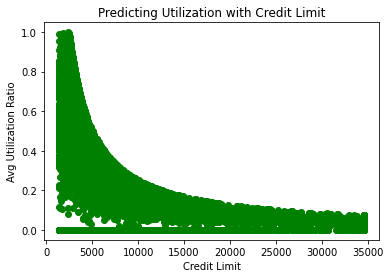

In [21]:
figure1, figure1_axes = plt.subplots()
figure1_axes.plot(creditLimit, avg_Utilization_Ratio, 'go',)
figure1_axes.set_xlabel('Credit Limit')
figure1_axes.set_ylabel('Avg Utilization Ratio')
figure1_axes.set_title('Predicting Utilization with Credit Limit');

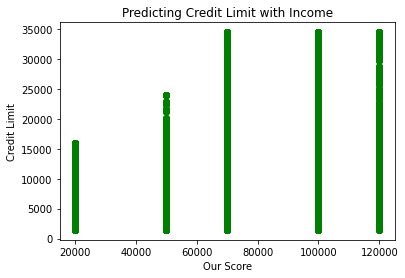

In [22]:
figure1, figure1_axes = plt.subplots()
figure1_axes.plot(income, creditLimit, 'go',)
figure1_axes.set_xlabel('Our Score')
figure1_axes.set_ylabel('Credit Limit')
figure1_axes.set_title('Predicting Credit Limit with Income');

We notice that income is not a good feature for predicting credit limit, however credit limit looks to be pretty good at predicting credit utilization

Customers with lower credit limits have on average 2.3 dependents, 36 months on the book, on average education level is college

### Picking our features
- Customer age = index (2)
- Gender = index (3)
- Dependent count = index (4)
- Edu level = index (5)
- Marital status = index (6)
- Income = index (7)
- Months on book = index (9)
- Total relationship count = index (10)
- Cred limit = index (13)
- Total revolving balance = index (14)
- Total trans amnt = index (17) 
- Util ratio = index (20)
    

In [23]:
# create empty list
features = []
targets = []

# for loop to create feature lists to add to above created list

for i in range(len(newDF)):
    feature = []
    credLimitY = ''
    
    credLimitY = newDF.iloc[i,13]
    # feature.append(newDF.iloc[i,2])
    # feature.append(newDF.iloc[i,3])
    feature.append(newDF.iloc[i,4])
    feature.append(newDF.iloc[i,5])
    feature.append(newDF.iloc[i,6])
    feature.append(newDF.iloc[i,7])
    # feature.append(newDF.iloc[i,9])
    # feature.append(newDF.iloc[i,10])
    feature.append(newDF.iloc[i,14])
    feature.append(newDF.iloc[i,17]) 
    feature.append(newDF.iloc[i,20])
    # feature.append(newDF.iloc[i,23])

    
    features.append(feature)
    targets.append(credLimitY)
    
print(features[:5])
print(targets[:5])

[[3, 0.5, 0.9, 70000, 777, 1144, 0.061], [5, 0.7, 0.8, 20000, 864, 1291, 0.105], [3, 0.7, 0.9, 100000, 0, 1887, 0.0], [4, 0.5, 0.8, 20000, 2517, 1171, 0.76], [3, 0.25, 0.9, 70000, 0, 816, 0.0]]
[12691.0, 8256.0, 3418.0, 3313.0, 4716.0]


## Training Model for all data

In [69]:
# Turn features and targets lists into numpy arrays
x_features = np.array(features)
y_targets = np.array(targets)

In [87]:
# Split the data into X_train, X_test, y_train, y_test
x_train, x_test, y_train, y_test = train_test_split(x_features, y_targets)

In [88]:
# create model
model = LinearRegression()
model.fit(x_features, y_targets)

LinearRegression()

In [94]:
scaler = StandardScaler()
X_norm = scaler.fit_transform(x_features)
print(f"Peak to Peak range by column in Raw        X:{np.ptp(x_features,axis=0)}")   
print(f"Peak to Peak range by column in Normalized X:{np.ptp(y_targets,axis=0)}")

Peak to Peak range by column in Raw        X:[5.00e+00 6.50e-01 2.00e-01 1.00e+05 2.52e+03 1.75e+04 9.99e-01]
Peak to Peak range by column in Normalized X:33077.7


In [95]:
sgdr = SGDRegressor(max_iter=100000)
sgdr.fit(X_norm, creditLimit)
print(sgdr)
print(f"number of iterations completed: {sgdr.n_iter_}, number of weight updates: {sgdr.t_}")

SGDRegressor(max_iter=100000)
number of iterations completed: 22, number of weight updates: 168103.0


In [96]:
b_norm = sgdr.intercept_
w_norm = sgdr.coef_
print(f"model parameters:                   w: {w_norm}, b:{b_norm}")

model parameters:                   w: [  284.4    -80.94  -395.29  3563.75  3483.19   718.72 -5445.81], b:[8652.99]


In [97]:
# make a prediction using sgdr.predict()
y_pred_sgd = sgdr.predict(X_norm)
# make a prediction using w,b. 
y_pred = np.dot(X_norm, w_norm) + b_norm  
print(f"prediction using np.dot() and sgdr.predict match: {(y_pred == y_pred_sgd).all()}")

print(f"Prediction on training set:\n{y_pred[:20]}" )
print(f"Target values \n{y_targets[:20]}")

prediction using np.dot() and sgdr.predict match: True
Prediction on training set:
[11888.    7286.15 12898.92  1384.77  9796.79  6633.21 14849.71 19111.25
 17584.4  18118.53 13065.22 13653.47  1852.79 22254.99  2653.05 16439.81
  3779.58  7594.09  8089.63 11971.49]
Target values 
[12691.   8256.   3418.   3313.   4716.   4010.  29081.  22352.  11656.
  6748.  11751.   8547.   2436.  30367.   3193.  20979.   1438.3  4470.
  7768.  14784. ]


In [100]:
# Use our model to make predictions
predicted = model.predict(x_test)

# Score the predictions with r2
mse = mean_squared_error(y_test, predicted)
r2 = r2_score(y_test, predicted)

print(mse)
print(f"R-squared (R2): {r2}")

38978999.05232473
R-squared (R2): 0.5632069123341864


In [101]:
# Display score
model.score(x_test, y_test)

0.5632069123341864

## Section where I'm attempting to define my own Gradient Descent functions

In [33]:
# --------------------------------------------- Section for testing manual gradient descent -----------------------------------------------------

In [34]:
# Print features and targets from above    
print(features[:5])
print(targets[:5])

[[3, 0.5, 0.9, 70000, 777, 1144, 0.061], [5, 0.7, 0.8, 20000, 864, 1291, 0.105], [3, 0.7, 0.9, 100000, 0, 1887, 0.0], [4, 0.5, 0.8, 20000, 2517, 1171, 0.76], [3, 0.25, 0.9, 70000, 0, 816, 0.0]]
[12691.0, 8256.0, 3418.0, 3313.0, 4716.0]


In [35]:
# --------------------------------------------- Section for testing manual gradient descent -----------------------------------------------------

In [36]:
# visualize data

X_train = np.array(features)
y_train = np.array(targets)

In [37]:
scaler = StandardScaler()
X_norm = scaler.fit_transform(X_train)
X_norm.shape

(7641, 7)

In [38]:
# data is stored in numpy array/matrix
print(f"X Shape: {X_norm.shape}, X Type:{type(X_norm)})")
print(X_train)
print(f"y Shape: {y_train.shape}, y Type:{type(y_train)})")
print(y_train)

X Shape: (7641, 7), X Type:<class 'numpy.ndarray'>)
[[3.00e+00 5.00e-01 9.00e-01 ... 7.77e+02 1.14e+03 6.10e-02]
 [5.00e+00 7.00e-01 8.00e-01 ... 8.64e+02 1.29e+03 1.05e-01]
 [3.00e+00 7.00e-01 9.00e-01 ... 0.00e+00 1.89e+03 0.00e+00]
 ...
 [1.00e+00 5.00e-01 9.00e-01 ... 0.00e+00 1.03e+04 0.00e+00]
 [2.00e+00 7.00e-01 8.00e-01 ... 0.00e+00 8.40e+03 0.00e+00]
 [2.00e+00 7.00e-01 9.00e-01 ... 1.96e+03 1.03e+04 1.89e-01]]
y Shape: (7641,), y Type:<class 'numpy.ndarray'>)
[12691.  8256.  3418. ...  5409.  5281. 10388.]


In [39]:
b_init = 8561.07
w_init = np.array([286.61, -154.2 , -475.49, 3517.54, 3529.85, 686.09, -5455.72])
print(f"w_init shape: {w_init.shape}, b_init type: {type(b_init)}")

w_init shape: (7,), b_init type: <class 'float'>


In [40]:
def predict(x, w, b): 
    """
    single predict using linear regression
    Args:
      x (ndarray): Shape (n,) example with multiple features
      w (ndarray): Shape (n,) model parameters   
      b (scalar):             model parameter 
      
    Returns:
      p (scalar):  prediction
    """
    p = np.dot(x, w) + b     
    return p  

In [41]:
# get a row from our training data
x_vec = X_norm[0,:]
print(f"x_vec shape {x_vec.shape}, x_vec value: {x_vec}")

# make a prediction
f_wb = predict(x_vec,w_init, b_init)
print(f"f_wb shape {f_wb.shape}, prediction: {f_wb}")

x_vec shape (7,), x_vec value: [ 0.5  -0.44  0.98  0.42 -0.48 -0.95 -0.79]
f_wb shape (), prediction: 11748.26799689738


In [42]:
def compute_cost(X, y, w, b): 
    """
    compute cost
    Args:
      X (ndarray (m,n)): Data, m examples with n features
      y (ndarray (m,)) : target values
      w (ndarray (n,)) : model parameters  
      b (scalar)       : model parameter
      
    Returns:
      cost (scalar): cost
    """
    m = X.shape[0]
    cost = 0.0
    for i in range(m):                                
        f_wb_i = np.dot(X[i], w) + b           #(n,)(n,) = scalar (see np.dot)
        cost = cost + (f_wb_i - y[i])**2       #scalar
    cost = cost / (2 * m)                      #scalar    
    return cost

In [43]:
# Compute and display cost using our pre-chosen optimal parameters. 
cost = compute_cost(X_norm, y_train, w_init, b_init)
print(f'Cost at optimal w : {cost}')

Cost at optimal w : 19149047.17550927


In [44]:
# OLD DONT RUN
# Cost at optimal w : 41745790.73400999

In [45]:
print(X_train.shape)
m,n = X_train.shape 
print(np.zeros((n,)))

(7641, 7)
[0. 0. 0. 0. 0. 0. 0.]


In [46]:
def compute_gradient(X, y, w, b): 
    """
    Computes the gradient for linear regression 
    Args:
      X (ndarray (m,n)): Data, m examples with n features
      y (ndarray (m,)) : target values
      w (ndarray (n,)) : model parameters  
      b (scalar)       : model parameter
      
    Returns:
      dj_dw (ndarray (n,)): The gradient of the cost w.r.t. the parameters w. 
      dj_db (scalar):       The gradient of the cost w.r.t. the parameter b. 
    """
    m,n = X.shape           #(number of examples, number of features)
    dj_dw = np.zeros((n,))
    dj_db = 0.

    for i in range(m):                             
        err = (np.dot(X[i], w) + b) - y[i]   
        for j in range(n):                         
            dj_dw[j] = dj_dw[j] + err * X[i, j]    
        dj_db = dj_db + err                        
    dj_dw = dj_dw / m                                
    dj_db = dj_db / m                                
        
    return dj_db, dj_dw

In [47]:
#Compute and display gradient 
tmp_dj_db, tmp_dj_dw = compute_gradient(X_norm, y_train, w_init, b_init)
print(f'dj_db at initial w,b: {tmp_dj_db}')
print(f'dj_dw at initial w,b: \n {tmp_dj_dw}')

dj_db at initial w,b: 1.8867909959872071
dj_dw at initial w,b: 
 [  61.55 -128.5   -73.54   43.62  -64.83  -91.46  -71.72]


In [48]:
def gradient_descent(X, y, w_in, b_in, cost_function, gradient_function, alpha, num_iters): 
    """
    Performs batch gradient descent to learn theta. Updates theta by taking 
    num_iters gradient steps with learning rate alpha
    
    Args:
      X (ndarray (m,n))   : Data, m examples with n features
      y (ndarray (m,))    : target values
      w_in (ndarray (n,)) : initial model parameters  
      b_in (scalar)       : initial model parameter
      cost_function       : function to compute cost
      gradient_function   : function to compute the gradient
      alpha (float)       : Learning rate
      num_iters (int)     : number of iterations to run gradient descent
      
    Returns:
      w (ndarray (n,)) : Updated values of parameters 
      b (scalar)       : Updated value of parameter 
      """
    
    # An array to store cost J and w's at each iteration primarily for graphing later
    J_history = []
    w = copy.deepcopy(w_in)  #avoid modifying global w within function
    b = b_in
    
    for i in range(num_iters):

        # Calculate the gradient and update the parameters
        dj_db,dj_dw = gradient_function(X, y, w, b)   ##None

        # Update Parameters using w, b, alpha and gradient
        w = w - alpha * dj_dw               ##None
        b = b - alpha * dj_db               ##None
      
        # Save cost J at each iteration
        if i<100000:      # prevent resource exhaustion 
            J_history.append( cost_function(X, y, w, b))

        # Print cost every at intervals 10 times or as many iterations if < 10
        if i% math.ceil(num_iters / 10) == 0:
            print(f"Iteration {i:4d}: Cost {J_history[-1]:8.2f}   ")
        
    return w, b, J_history #return final w,b and J history for graphing

In [49]:
# initialize parameters
initial_w = np.array([286.61, -154.2 , -475.49, 3517.54, 3529.85, 686.09, -5455.72])
initial_b = 8561.07
# some gradient descent settings
iterations = 1000
alpha = 0.01
# run gradient descent 
w_final, b_final, J_hist = gradient_descent(X_norm, y_train, initial_w, initial_b,
                                                    compute_cost, compute_gradient, 
                                                    alpha, iterations)
print(f"b,w found by gradient descent: {b_final:0.2f},{w_final} ")
m,_ = X_train.shape
for i in range(m):
    pred = np.dot(X_norm[i], w_final) + b_final
    # print(f"prediction: {pred}, target value: {y_train[i]}")

Iteration    0: Cost 19148596.53   
Iteration  100: Cost 19130824.20   
Iteration  200: Cost 19128629.94   
Iteration  300: Cost 19128319.72   
Iteration  400: Cost 19128271.95   
Iteration  500: Cost 19128263.12   
Iteration  600: Cost 19128260.71   
Iteration  700: Cost 19128259.70   
Iteration  800: Cost 19128259.17   
Iteration  900: Cost 19128258.86   
b,w found by gradient descent: 8559.18,[  225.13   -25.27  -399.97  3491.33  3558.02   787.37 -5407.95] 


## The cost descrease 